In [1]:
import numpy as np
from scipy import sparse

def laplacian_pe(A, k):
    """
    
    Example:
        
    from toponetx.classes.simplicial_complex import SimplicialComplex
    
    sc=SimplicialComplex([[1,2,3],[2,3,5]])
    
    A=sc.adjacency_matrix(1)
    
    pe=laplacian_pe(A,8)
    """
    n = A.shape[0]
    # Compute the degree matrix D^-0.5
    D = sparse.diags(np.squeeze(np.asarray(np.power(np.sum(A, axis=1), -0.5))))
    
    # Compute the Laplacian matrix L = I - D^-0.5 * A * D^-0.5
    L = np.eye(A.shape[0]) - D @ A @ D
    
    # Compute the eigenvectors of L
    EigVal, EigVec = np.linalg.eig(L)

    # Select the k smallest non-trivial eigenvectors
    max_freqs = min(A.shape[0] - 1, k)
    kpartition_indices = np.argpartition(EigVal, max_freqs)[:max_freqs+1]
    topk_eigvals = EigVal[kpartition_indices]
    topk_indices = kpartition_indices[topk_eigvals.argsort()][1:]
    topk_EigVec = EigVec[:, topk_indices]

    # Randomly flip signs of the eigenvectors
    rand_sign = 2 * (np.random.rand(max_freqs) > 0.5) - 1.0
    PE = np.multiply(rand_sign , topk_EigVec.astype(np.float32))

    if n <= k:
            temp_EigVec = np.zeros((n, k - n + 1), dtype=np.float32)
            PE = np.concatenate((PE, temp_EigVec), axis=1)
            temp_EigVal = np.full(k - n + 1, np.nan, dtype=np.float32)
            eigvals = np.concatenate((topk_eigvals, temp_EigVal), axis=0)
    else:
        eigvals = topk_eigvals

    # Return the Laplacian positional encodings
    return PE



In [64]:
import toponetx as tnx
from toponetx.classes.simplicial_complex import SimplicialComplex
    
#cc = tnx.classes.CellComplex([[1, 2, 3, 4, 5], [4, 5, 6]], ranks=2)

ccc = tnx.classes.CombinatorialComplex()

ccc.add_cell([2,5],rank=1)

ccc.add_cell([2,4],rank=1)

ccc.add_cell([7,8],rank=1)
ccc.add_cell([6,8],rank=1)


ccc.add_cell([2,4,5],rank=3)
ccc.add_cell([6,7,8],rank=3)

index,A = ccc.adjacency_matrix(0,3,index=True)
print(A.todense())    
pe=laplacian_pe(A,2)
d={}
for i,v in zip(index,pe):
    d[i] = np.array(v[0]).reshape(2,)


[[0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 0]
 [0 0 0 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]]


array([[-0.        ,  0.07146285],
       [-0.        ,  0.66866177],
       [-0.        , -0.74012464],
       [ 0.57735026, -0.        ],
       [ 0.57735026, -0.        ],
       [ 0.57735026, -0.        ]])

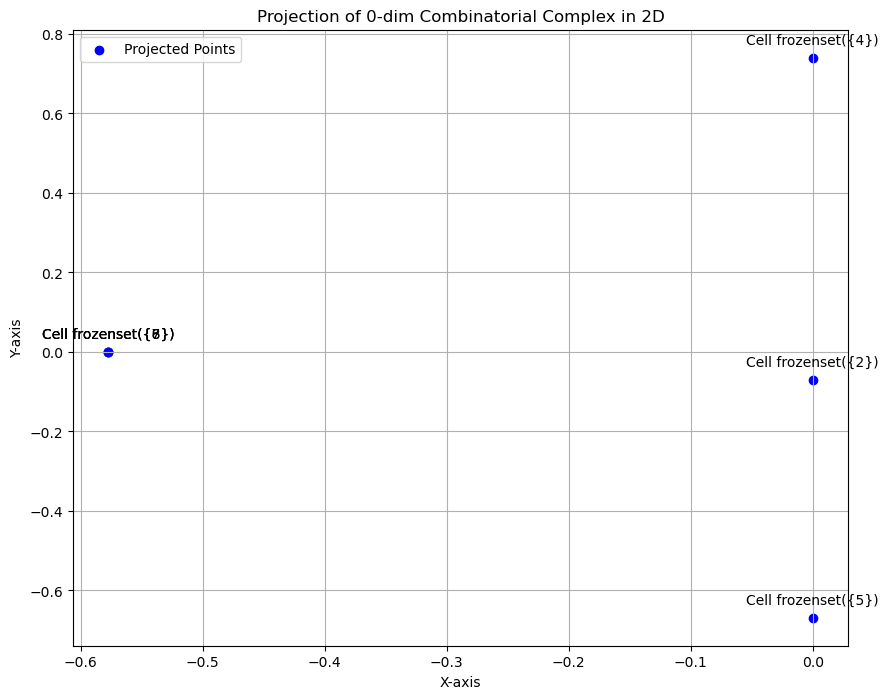

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import topoembedx as tex
import toponetx as tnx

# Create a cell complex object with a few cells
ccc = tnx.classes.CombinatorialComplex()


ccc.add_cell([2,4,5],rank=3)
ccc.add_cell([6,7,8],rank=3)

# Create a model
model = tex.DeepCell(dimensions=2)

# Fit the model to the cell complex
model.fit(ccc, neighborhood_type="adj", neighborhood_dim={"r": 0, "k" :3})

# Get the embeddings
embedded_points = model.get_embedding(get_dict=True)
embedded_points = d
# Prepare data for plotting
x = [embedded_points[cell][0] for cell in embedded_points]
y = [embedded_points[cell][1] for cell in embedded_points]
cell_labels = [f'Cell {cell}' for cell in embedded_points]

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c='blue', label='Projected Points')

# Annotate the points to correspond with cells
for i, label in enumerate(cell_labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Label axes and add title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Projection of 0-dim Combinatorial Complex in 2D')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()


